In [2]:
#import cv2, sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Image Load

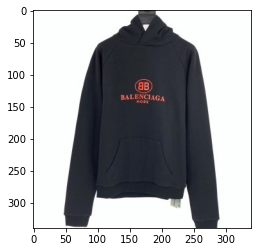

In [4]:
img = Image.open('./sampleImage/hood.jpg')
img = img.convert("RGBA")
datas = img.getdata()
plt.imshow(img)

# Image backround default

In [5]:
img = img.resize((128, 128))
datas = img.getdata()

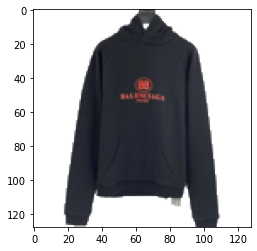

In [6]:
newData = []
cutOff = 200
 
for item in datas:
    if item[0] >= cutOff and item[1] >= cutOff and item[2] >= cutOff:
        newData.append((255, 255, 255, 0))
        # if RGB value is over cutoff, consider as background (white)
    else:
        newData.append(item)
        # don't change others
 
img.putdata(newData)
img.save("crop.png", "PNG")
plt.imshow(img)

In [7]:
img_pixel = pd.DataFrame(np.array(newData))
img_pixel.head()

,0,1,2,3
0,255,255,255,0
1,255,255,255,0
2,255,255,255,0
3,255,255,255,0
4,255,255,255,0
...,...,...,...,...
16379,255,255,255,0
16380,255,255,255,0
16381,255,255,255,0
16382,255,255,255,0


In [8]:
# 투명과 불투명 두 개의 조건 있음
img_pixel[3].unique()

array([  0, 255])

In [9]:
# 투명한 pixel = 배경이므로 drop함.
drop_idx = img_pixel[img_pixel[3] == 0].index
drop_idx

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            16374, 16375, 16376, 16377, 16378, 16379, 16380, 16381, 16382,
            16383],
           dtype='int64', length=8260)

In [10]:
img_pixel = img_pixel.drop(drop_idx)
img_pixel.head()

,0,1,2,3
62,91,91,93,255
63,89,88,92,255
64,89,88,93,255
65,71,70,76,255
66,55,58,62,255
...,...,...,...,...
16359,44,47,56,255
16360,44,47,56,255
16361,45,48,57,255
16362,45,48,57,255


In [11]:
# 분석시에 투명도는 사용하지 안으므로 drop함
pixels = img_pixel.drop(columns=[3], axis=1)
pixels.head()

,0,1,2
62,91,91,93
63,89,88,92
64,89,88,93
65,71,70,76
66,55,58,62
...,...,...,...
16359,44,47,56
16360,44,47,56
16361,45,48,57
16362,45,48,57


# Color functions

In [12]:
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [13]:
def hex_to_rgb(color):
    color = color.lstrip('#')
    lv = len(color)
    return tuple(int(color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

# Clustering - Silhouette Score

In [14]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from collections import Counter
# import os

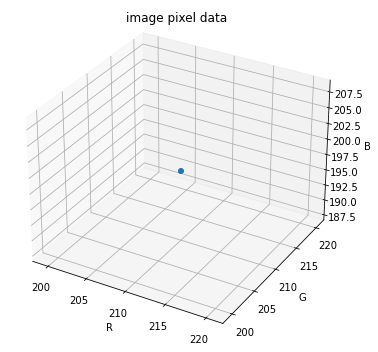

In [18]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(pixels[0], pixels[1], pixels[2]);
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_title('image pixel data', y=1.02)

plt.tight_layout()
plt.savefig(f'knit128_pixel_plot.png')
plt.show()

In [15]:
# silhouette plot

def silhouette_plot(score):
    y_ticks = []
    y_lower = y_upper = 0

    for i,cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        ax = fig.gca()
      
        ax.barh(range(y_lower,y_upper), cluster_silhouette_vals, height = 1)
        ax.text(-0.03,(y_lower+y_upper)/2,str(i+1))
        y_lower += len(cluster_silhouette_vals)
          
        # Get the average silhouette score 
        avg_score = np.mean(silhouette_vals)
        ax.axvline(avg_score,linestyle ='--', linewidth =2,color = 'green')
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1])
        ax.set_xlabel('Silhouette coefficient values')
        ax.set_ylabel('Cluster labels')
        ax.set_title(f'Silhouette Score = {score: .5f}');
        
        plt.savefig(f'Silhouette_analysis_{n}.png')
        
    for i,cluster in enumerate(np.unique(labels)):
        # scatter plot of data colored with labels
        ax = fig.gca(projection='3d')

        ax.scatter(pixels[0], pixels[1], pixels[2] , c = labels);
        ax.scatter(centroid[:,0],centroid[:,1], centroid[:,2], marker = '*' , c= 'r',s =250);
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        ax.set_title(f'n_cluster={n}', y=1.02)

        plt.tight_layout()
#         plt.suptitle(f" Silhouette analysis using cluster = {n} \n Score = {score:.3f}",fontsize=16,fontweight = 'semibold')
        plt.savefig(f'pixel_clustered_{n}.png')

In [19]:
sil = []

In [35]:
%%time

for n in range(2, 12):
    fig = plt.figure(figsize=(15,5))
    
    if len(pixels) <= n or len(pixels[pixels.duplicated([0, 1, 2]) == False]) <= n:
        break

    clf = MiniBatchKMeans(n_clusters = n, init = 'k-means++', random_state = 10)
    labels = clf.fit_predict(pixels)
    centroid  = clf.cluster_centers_

    score = silhouette_score(pixels, labels, metric='euclidean')
    silhouette_vals = silhouette_samples(pixels, labels)
    sil.append(score)

    silhouette_plot(score)
    
    print(f"{n} clusters silhouette score = {score}")

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
len(sil)

0

# Clustering - KMeans

In [101]:
sil_max = sil.index(max(sil)) + 2
sil_max

2

In [102]:
max(sil)

0.7173532678394399

In [103]:
# number_of_colors = sil_max
if max(sil) < 0.5:
    number_of_colors = 1
else:
    sil_max = sil.index(max(sil)) + 2
    number_of_colors = sil_max

In [16]:
%%time

clf = MiniBatchKMeans(n_clusters = number_of_colors, init = 'k-means++', random_state = 10)
labels = clf.fit_predict(pixels)

CPU times: total: 15.6 ms
Wall time: 26 ms


In [17]:
counts = Counter(labels)
counts

Counter({1: 356, 0: 7768})

In [18]:
center_colors = clf.cluster_centers_
hex_colors = [rgb_to_hex(center_colors[i]) for i in counts.keys()]

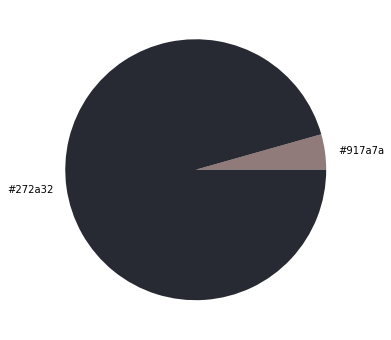

In [19]:
if (True):
    plt.figure(figsize = (8, 6))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    plt.savefig(f'knit128_KMeans_pie.png')
    plt.show()

In [20]:
hex_colors

['#917a7a', '#272a32']

In [21]:
hex_to_rgb(hex_colors[0])

(145, 122, 122)

In [22]:
# clustered pixel number
pixel_num = []
for i in counts.values():
    pixel_num.append(i)
pixel_num

[356, 7768]

# Color Identification

In [216]:
from math import dist

In [217]:
rgb_data = pd.read_csv('./colorChart/colorChart_11.csv')
rgb_data

,index,name,R,G,B
0,0,aqua,0,255,255
1,1,black,0,0,0
2,2,blue,0,0,255
3,3,fuchsia,255,0,255
4,4,green,0,128,0
5,5,lime,0,255,0
6,6,maroon,128,0,0
7,7,navy,0,0,128
8,8,red,255,0,0
9,9,white,255,255,255


In [218]:
rgbs = rgb_data[['R', 'G', 'B']].values.tolist()
rgbs

[[0, 255, 255],
 [0, 0, 0],
 [0, 0, 255],
 [255, 0, 255],
 [0, 128, 0],
 [0, 255, 0],
 [128, 0, 0],
 [0, 0, 128],
 [255, 0, 0],
 [255, 255, 255],
 [255, 255, 0]]

In [219]:
# Calculate the Euclidean distance and get the index of the closest color
def color_dist(hex_s):
    color_index = []
    
    for i in range(len(hex_s)):
        min_color = 10000
        min_index = 0
        
        for j in range(len(rgbs)):
            distance = dist(hex_to_rgb(hex_s[i]), tuple(rgbs[j]))

            if distance < min_color:
                min_color = distance
                min_index = j
                
        color_index.append(min_index)
            
    return color_index

In [220]:
c_name = color_dist(hex_colors)
c_name

[9, 7]

In [221]:
# Returns the index of the color with the greatest weight
def max_color(c_name):
    c_per = [0] * len(rgbs)

    for i in range(len(c_name)):
        c_per[c_name[i]] +=  pixel_num[i]

    return rgb_data[rgb_data['index'] == c_per.index(max(c_per))]['name']
#     return c_per.index(max(c_per))

In [222]:
max_color(c_name)

7    navy
Name: name, dtype: object